In [4]:
# NCAA Basketball Betting Model Functions

import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
import pickle

# Define good line columns
good_line_columns = [
    'line', 'lineavg', 'linemoore', 'lineopen', 'linedok', 
    'linefox', 'linepugh', 'linetalis', 'lineespn', 'line7ot',
    'linemassey', 'lineround', 'lineteamrnks'
]

# Define features
features = [
    'line', 'lineavg', 'linemoore', 'linemassey', 'std',
    'line_movement', 'line_std', 'line_value',
    'linemassey_diff', 'linemoore_diff', 'lineavg_diff',
    'month', 'day_of_week', 'neutral'
]

# Function to train model directly in notebook
def train_betting_model(train_data):
    """Train a new betting model on the provided training data."""
    # Data preprocessing
    data_clean = train_data.copy()
    
    # Convert date to datetime
    data_clean['date'] = pd.to_datetime(data_clean['date'], format='%m/%d/%Y')
    data_clean['month'] = data_clean['date'].dt.month
    data_clean['day_of_week'] = data_clean['date'].dt.dayofweek
    
    # Create target variable
    data_clean['home_margin'] = data_clean['hscore'] - data_clean['rscore']
    data_clean['home_covered'] = np.where(data_clean['line'] > 0, 
                                          data_clean['home_margin'] > data_clean['line'],  # Home is favored
                                          data_clean['home_margin'] > data_clean['line'])  # Road is favored
    
    # Calculate derived features
    data_clean['line_movement'] = data_clean['line'] - data_clean['lineopen']
    data_clean['line_std'] = data_clean[good_line_columns].std(axis=1)
    data_clean['consensus_line'] = data_clean[['linemassey', 'linemoore', 'lineavg']].mean(axis=1)
    data_clean['line_value'] = data_clean['line'] - data_clean['consensus_line']
    
    for col in ['lineavg', 'linemoore', 'linemassey']:
        data_clean[f'{col}_diff'] = data_clean['line'] - data_clean[col]
    
    # Define X and y
    X = data_clean[features]
    y = data_clean['home_covered']
    
    # Define and train model
    model_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', GradientBoostingClassifier(n_estimators=100, random_state=42))
    ])
    
    model_pipeline.fit(X, y)
    
    return model_pipeline

# Function to save model
def save_model(model, filepath="betting_model.pkl"):
    """Save the trained model to a file"""
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {filepath}")

# Function to load model
def load_model(filepath="betting_model.pkl"):
    """Load a trained model from a file"""
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    return model

# Function to make predictions
def predict_games(model, games_data, threshold=0.65):
    """Make predictions for games using the trained model."""
    # Preprocess the games data
    processed_data = games_data.copy()
    
    # Convert date to datetime
    processed_data['date'] = pd.to_datetime(processed_data['date'], format='%m/%d/%Y')
    processed_data['month'] = processed_data['date'].dt.month
    processed_data['day_of_week'] = processed_data['date'].dt.dayofweek
    
    # Calculate derived features
    processed_data['line_movement'] = processed_data['line'] - processed_data['lineopen']
    processed_data['line_std'] = processed_data[good_line_columns].std(axis=1)
    processed_data['consensus_line'] = processed_data[['linemassey', 'linemoore', 'lineavg']].mean(axis=1)
    processed_data['line_value'] = processed_data['line'] - processed_data['consensus_line']
    
    for col in ['lineavg', 'linemoore', 'linemassey']:
        processed_data[f'{col}_diff'] = processed_data['line'] - processed_data[col]
    
    # Ensure all required features are present
    for feature in features:
        if feature not in processed_data.columns:
            processed_data[feature] = 0  # Default to 0 if missing
    
    # Get features for prediction
    X = processed_data[features]
    
    # Make predictions
    try:
        pred_proba = model.predict_proba(X)
        predictions = model.predict(X)
        
        # Add predictions to results
        results = processed_data.copy()
        results['predicted_covered'] = predictions
        results['confidence'] = np.max(pred_proba, axis=1)
        results['p_covered'] = pred_proba[:, 1]
        results['bet'] = results['confidence'] >= threshold
        
        # Add prediction details
        def get_prediction_detail(row):
            line = row['line']
            if row['predicted_covered'] == 1:  # Model predicts cover
                if line > 0:
                    return f"{row['home']} to cover as {line}-point favorite"
                else:
                    return f"{row['home']} to cover as {abs(line)}-point underdog"
            else:  # Model predicts no cover
                if line > 0:
                    return f"{row['road']} to cover against {line}-point home favorite"
                else:
                    return f"{row['road']} to cover as {abs(line)}-point favorite"
        
        results['prediction_detail'] = results.apply(get_prediction_detail, axis=1)
        
        return results
    
    except Exception as e:
        print(f"Error making predictions: {e}")
        print("Feature shapes:", X.shape)
        print("Features head:", X.head())
        print("Missing values in features:", X.isnull().sum())
        return None

In [5]:
# Load your data
data_2023 = pd.read_csv('ncaabb23.csv')

# Train model
model = train_betting_model(data_2023)

# Save model for future use
save_model(model, 'ncaa_betting_model.pkl')

# When you want to load it in the future:
# model = load_model('ncaa_betting_model.pkl')

# If you have 2024 data for testing, uncomment these lines:
# data_2024 = pd.read_csv('ncaabb24.csv')
# predictions = predict_games(model, data_2024, threshold=0.65)
# recommended_bets = predictions[predictions['bet']].sort_values('confidence', ascending=False)
# recommended_bets[['date', 'home', 'road', 'line', 'prediction_detail', 'confidence']]

Model saved to ncaa_betting_model.pkl


In [11]:
data_2023 = pd.read_csv('ncaabb23.csv')
data_2024 = pd.read_csv('ncaabb24.csv')  # For testing/prediction

# Train model (or load pre-trained model)
# model = train_betting_model(data_2023)
# save_model(model, 'ncaa_betting_model.pkl')
model = load_model('ncaa_betting_model.pkl')

# Make predictions
predictions = predict_games(model, data_2024, threshold=0.65)

# View recommended bets
recommended_bets = predictions[predictions['bet']].sort_values('confidence', ascending=False)
display(recommended_bets[['date', 'home', 'road', 'line', 'prediction_detail', 'confidence']])

# Evaluate performance (if you have actual results)
performance = evaluate_model(model, data_2024)
print(f"Accuracy: {performance['accuracy']:.3f}")
print(f"ROI: {performance['roi']:.2f}%")
print(f"Games predicted: {performance['games_predicted']} out of {performance['games_total']}")

# Find optimal threshold
threshold_performance = find_optimal_threshold(model, data_2024)

,date,home,road,line,prediction_detail,confidence
177,2024-11-08,Cincinnati,Morehead St.,29.5,Morehead St. to cover against 29.5-point home ...,0.934433
716,2024-11-21,Clemson,Radford,22.0,Radford to cover against 22.0-point home favorite,0.901381
623,2024-11-18,San Diego St.,Gonzaga,-10.0,Gonzaga to cover as 10.0-point favorite,0.895443
1080,2024-11-27,Pacific,Arkansas Pine Bluff,17.5,Arkansas Pine Bluff to cover against 17.5-poin...,0.881696
288,2024-11-10,Creighton,Fairleigh Dickinson,37.0,Fairleigh Dickinson to cover against 37.0-poin...,0.867008
...,...,...,...,...,...,...
2694,2025-01-11,Ohio,Northern Illinois,20.0,Northern Illinois to cover against 20.0-point ...,0.651039
2463,2025-01-07,Morgan St.,NC Central,-3.0,Morgan St. to cover as 3.0-point underdog,0.650606
2462,2025-01-07,Morgan St.,NC Central,-3.0,Morgan St. to cover as 3.0-point underdog,0.650606
1193,2024-11-30,Howard,Mount St. Marys,7.5,Mount St. Marys to cover against 7.5-point hom...,0.650454


Accuracy: 0.513
ROI: -2.10%
Games predicted: 312 out of 5450
Optimal threshold for 53%+ accuracy: 0.85
Performance at optimal threshold:
threshold     0.850000
accuracy      0.714286
games         7.000000
roi          36.363636
Name: 7, dtype: float64


In [6]:
# NCAA Basketball Betting Prediction Script
# For use in Jupyter Notebooks

import pandas as pd
import numpy as np
import pickle
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer

# Define functions for preprocessing and prediction
def preprocess_game(game_data, good_line_columns):
    """Preprocess a single game for prediction"""
    # Convert to DataFrame if it's a dict
    if isinstance(game_data, dict):
        game_df = pd.DataFrame([game_data])
    else:
        game_df = game_data.copy()
    
    # Convert date to datetime
    if 'date' in game_df.columns:
        game_df['date'] = pd.to_datetime(game_df['date'], format='%m/%d/%Y')
        game_df['month'] = game_df['date'].dt.month
        game_df['day_of_week'] = game_df['date'].dt.dayofweek
    else:
        # If no date provided, use current date
        now = datetime.now()
        game_df['month'] = now.month
        game_df['day_of_week'] = now.weekday()
    
    # Calculate derived features (same as in training)
    game_df['line_movement'] = game_df['line'] - game_df['lineopen']
    
    # Handle potential missing columns
    for col in good_line_columns:
        if col not in game_df.columns:
            game_df[col] = np.nan
    
    game_df['line_std'] = game_df[good_line_columns].std(axis=1, skipna=True)
    game_df['consensus_line'] = game_df[['linemassey', 'linemoore', 'lineavg']].mean(axis=1)
    game_df['line_value'] = game_df['line'] - game_df['consensus_line']
    
    for col in ['lineavg', 'linemoore', 'linemassey']:
        game_df[f'{col}_diff'] = game_df['line'] - game_df[col]
    
    return game_df

def predict_games(model, games_data, threshold=0.65):
    """
    Make predictions for games using the trained model.
    
    Parameters:
    model (Pipeline or estimator): Trained model
    games_data (DataFrame): Data for games to predict
    threshold (float): Confidence threshold
    
    Returns:
    DataFrame: Predictions with confidence scores
    """
    # Define features and good line columns
    features = [
        'line', 'lineavg', 'linemoore', 'linemassey', 'std',
        'line_movement', 'line_std', 'line_value',
        'linemassey_diff', 'linemoore_diff', 'lineavg_diff',
        'month', 'day_of_week', 'neutral'
    ]
    
    good_line_columns = [
        'line', 'lineavg', 'linemoore', 'lineopen', 'linedok', 
        'linefox', 'linepugh', 'linetalis', 'lineespn', 'line7ot',
        'linemassey', 'lineround', 'lineteamrnks'
    ]
    
    # Preprocess the games data
    processed_data = preprocess_game(games_data, good_line_columns)
    
    # Ensure all required features are present
    for feature in features:
        if feature not in processed_data.columns:
            processed_data[feature] = 0  # Default to 0 if missing
    
    # Get features for prediction
    X = processed_data[features]
    
    # Make predictions
    try:
        pred_proba = model.predict_proba(X)
        predictions = model.predict(X)
        
        # Add predictions to results
        results = processed_data.copy()
        results['predicted_covered'] = predictions
        results['confidence'] = np.max(pred_proba, axis=1)
        results['p_covered'] = pred_proba[:, 1]
        results['bet'] = results['confidence'] >= threshold
        
        # Add prediction details
        def get_prediction_detail(row):
            line = row['line']
            if row['predicted_covered'] == 1:  # Model predicts cover
                if line > 0:
                    return f"{row['home']} to cover as {line}-point favorite"
                else:
                    return f"{row['home']} to cover as {abs(line)}-point underdog"
            else:  # Model predicts no cover
                if line > 0:
                    return f"{row['road']} to cover against {line}-point home favorite"
                else:
                    return f"{row['road']} to cover as {abs(line)}-point favorite"
        
        results['prediction_detail'] = results.apply(get_prediction_detail, axis=1)
        
        return results
    
    except Exception as e:
        print(f"Error making predictions: {e}")
        print("Feature shapes:", X.shape)
        print("Features head:", X.head())
        print("Missing values in features:", X.isnull().sum())
        return None

# Function to train model directly in notebook
def train_betting_model(train_data):
    """
    Train a new betting model on the provided training data.
    
    Parameters:
    train_data (DataFrame): Training data with necessary columns
    
    Returns:
    model: Trained model
    """
    # Data preprocessing
    data_clean = train_data.copy()
    
    # Convert date to datetime
    data_clean['date'] = pd.to_datetime(data_clean['date'], format='%m/%d/%Y')
    data_clean['month'] = data_clean['date'].dt.month
    data_clean['day_of_week'] = data_clean['date'].dt.dayofweek
    
    # Create target variable
    data_clean['home_margin'] = data_clean['hscore'] - data_clean['rscore']
    data_clean['home_covered'] = np.where(data_clean['line'] > 0, 
                                          data_clean['home_margin'] > data_clean['line'],  # Home is favored
                                          data_clean['home_margin'] > data_clean['line'])  # Road is favored
    
    # Define line columns and feature engineering
    good_line_columns = [
        'line', 'lineavg', 'linemoore', 'lineopen', 'linedok', 
        'linefox', 'linepugh', 'linetalis', 'lineespn', 'line7ot',
        'linemassey', 'lineround', 'lineteamrnks'
    ]
    
    # Calculate derived features
    data_clean['line_movement'] = data_clean['line'] - data_clean['lineopen']
    data_clean['line_std'] = data_clean[good_line_columns].std(axis=1)
    data_clean['consensus_line'] = data_clean[['linemassey', 'linemoore', 'lineavg']].mean(axis=1)
    data_clean['line_value'] = data_clean['line'] - data_clean['consensus_line']
    
    for col in ['lineavg', 'linemoore', 'linemassey']:
        data_clean[f'{col}_diff'] = data_clean['line'] - data_clean[col]
    
    # Define features
    features = [
        'line', 'lineavg', 'linemoore', 'linemassey', 'std',
        'line_movement', 'line_std', 'line_value',
        'linemassey_diff', 'linemoore_diff', 'lineavg_diff',
        'month', 'day_of_week', 'neutral'
    ]
    
    # Define X and y
    X = data_clean[features]
    y = data_clean['home_covered']
    
    # Define and train model
    model_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', GradientBoostingClassifier(n_estimators=100, random_state=42))
    ])
    
    model_pipeline.fit(X, y)
    
    return model_pipeline

# Function to save model
def save_model(model, filepath="betting_model.pkl"):
    """Save the trained model to a file"""
    import pickle
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {filepath}")

# Function to load model
def load_model(filepath="betting_model.pkl"):
    """Load a trained model from a file"""
    import pickle
    with open(filepath, 'rb') as f:
        model = pickle.load(f)
    return model

# Function to evaluate model on test data
def evaluate_model(model, test_data, threshold=0.65):
    """
    Evaluate model performance on test data.
    
    Parameters:
    model: Trained model
    test_data (DataFrame): Test data with actual results
    threshold (float): Confidence threshold
    
    Returns:
    dict: Performance metrics
    """
    # Preprocess test data
    predictions = predict_games(model, test_data, threshold)
    
    # Add actual results
    predictions['home_margin'] = predictions['hscore'] - predictions['rscore']
    predictions['actual_covered'] = np.where(predictions['line'] > 0, 
                                           predictions['home_margin'] > predictions['line'],
                                           predictions['home_margin'] > predictions['line'])
    
    # Filter high confidence predictions
    high_conf = predictions[predictions['bet']]
    
    if len(high_conf) == 0:
        return {"error": "No games meet the confidence threshold"}
    
    # Calculate accuracy
    correct = (high_conf['predicted_covered'] == high_conf['actual_covered']).sum()
    total = len(high_conf)
    accuracy = correct / total
    
    # Calculate ROI
    roi = (correct * 100 - (total - correct) * 110) / (total * 110) * 100
    
    return {
        "games_predicted": total,
        "games_total": len(predictions),
        "prediction_rate": total / len(predictions),
        "correct_predictions": correct,
        "accuracy": accuracy,
        "roi": roi
    }

# Function to find optimal threshold
def find_optimal_threshold(model, test_data, start=0.5, end=0.95, step=0.05):
    """
    Find the optimal confidence threshold that maximizes ROI with accuracy >= 53%.
    
    Parameters:
    model: Trained model
    test_data (DataFrame): Test data with actual results
    start (float): Starting threshold
    end (float): Ending threshold
    step (float): Step size
    
    Returns:
    DataFrame: Threshold performance metrics
    """
    thresholds = np.arange(start, end + step, step)
    results = []
    
    for threshold in thresholds:
        metrics = evaluate_model(model, test_data, threshold)
        if "error" not in metrics:
            results.append({
                "threshold": threshold,
                "accuracy": metrics["accuracy"],
                "games": metrics["games_predicted"],
                "roi": metrics["roi"]
            })
    
    # Convert to DataFrame
    threshold_df = pd.DataFrame(results)
    
    # Find optimal threshold (best ROI with accuracy >= 53%)
    valid_thresholds = threshold_df[threshold_df['accuracy'] >= 0.53]
    if len(valid_thresholds) > 0:
        optimal_idx = valid_thresholds['roi'].idxmax()
        optimal_threshold = valid_thresholds.loc[optimal_idx, 'threshold']
        print(f"Optimal threshold for 53%+ accuracy: {optimal_threshold:.2f}")
        print(f"Performance at optimal threshold:")
        print(valid_thresholds.loc[optimal_idx])
    else:
        print("No threshold meets the 53%+ accuracy requirement")
    
    return threshold_df

# Example usage in a notebook:

# Load data
data_2023 = pd.read_csv('ncaabb23.csv')
data_2024 = pd.read_csv('ncaabb24.csv')  # For testing/prediction

# Train model (or load pre-trained model)
# model = train_betting_model(data_2023)
# save_model(model, 'ncaa_betting_model.pkl')
model = load_model('ncaa_betting_model.pkl')

# Make predictions
predictions = predict_games(model, data_2024, threshold=0.65)

# View recommended bets
recommended_bets = predictions[predictions['bet']].sort_values('confidence', ascending=False)
display(recommended_bets[['date', 'home', 'road', 'line', 'prediction_detail', 'confidence']])

# Evaluate performance (if you have actual results)
performance = evaluate_model(model, data_2024)
print(f"Accuracy: {performance['accuracy']:.3f}")
print(f"ROI: {performance['roi']:.2f}%")
print(f"Games predicted: {performance['games_predicted']} out of {performance['games_total']}")

# Find optimal threshold
threshold_performance = find_optimal_threshold(model, data_2024)


,date,home,road,line,prediction_detail,confidence
177,2024-11-08,Cincinnati,Morehead St.,29.5,Morehead St. to cover against 29.5-point home ...,0.934433
716,2024-11-21,Clemson,Radford,22.0,Radford to cover against 22.0-point home favorite,0.901381
623,2024-11-18,San Diego St.,Gonzaga,-10.0,Gonzaga to cover as 10.0-point favorite,0.895443
1080,2024-11-27,Pacific,Arkansas Pine Bluff,17.5,Arkansas Pine Bluff to cover against 17.5-poin...,0.881696
288,2024-11-10,Creighton,Fairleigh Dickinson,37.0,Fairleigh Dickinson to cover against 37.0-poin...,0.867008
...,...,...,...,...,...,...
2694,2025-01-11,Ohio,Northern Illinois,20.0,Northern Illinois to cover against 20.0-point ...,0.651039
2463,2025-01-07,Morgan St.,NC Central,-3.0,Morgan St. to cover as 3.0-point underdog,0.650606
2462,2025-01-07,Morgan St.,NC Central,-3.0,Morgan St. to cover as 3.0-point underdog,0.650606
1193,2024-11-30,Howard,Mount St. Marys,7.5,Mount St. Marys to cover against 7.5-point hom...,0.650454


Accuracy: 0.513
ROI: -2.10%
Games predicted: 312 out of 5450
Optimal threshold for 53%+ accuracy: 0.85
Performance at optimal threshold:
threshold     0.850000
accuracy      0.714286
games         7.000000
roi          36.363636
Name: 7, dtype: float64


Performance at different confidence thresholds:
   threshold  games  accuracy        roi  percentage_of_total
0       0.55   1886  0.845175  61.351586            33.546781
1       0.60    651  0.966206  84.457478            11.579509
2       0.65    304  0.983553  87.769139             5.407328
3       0.70    152  1.000000  90.909091             2.703664
4       0.75     81  1.000000  90.909091             1.440768
5       0.80     39  1.000000  90.909091             0.693703
6       0.85     17  1.000000  90.909091             0.302383
7       0.90      2  1.000000  90.909091             0.035575

Thresholds meeting 53%+ accuracy criterion:
   threshold  games  accuracy        roi  percentage_of_total
0       0.55   1886  0.845175  61.351586            33.546781
1       0.60    651  0.966206  84.457478            11.579509
2       0.65    304  0.983553  87.769139             5.407328
3       0.70    152  1.000000  90.909091             2.703664
4       0.75     81  1.000000  90.90909

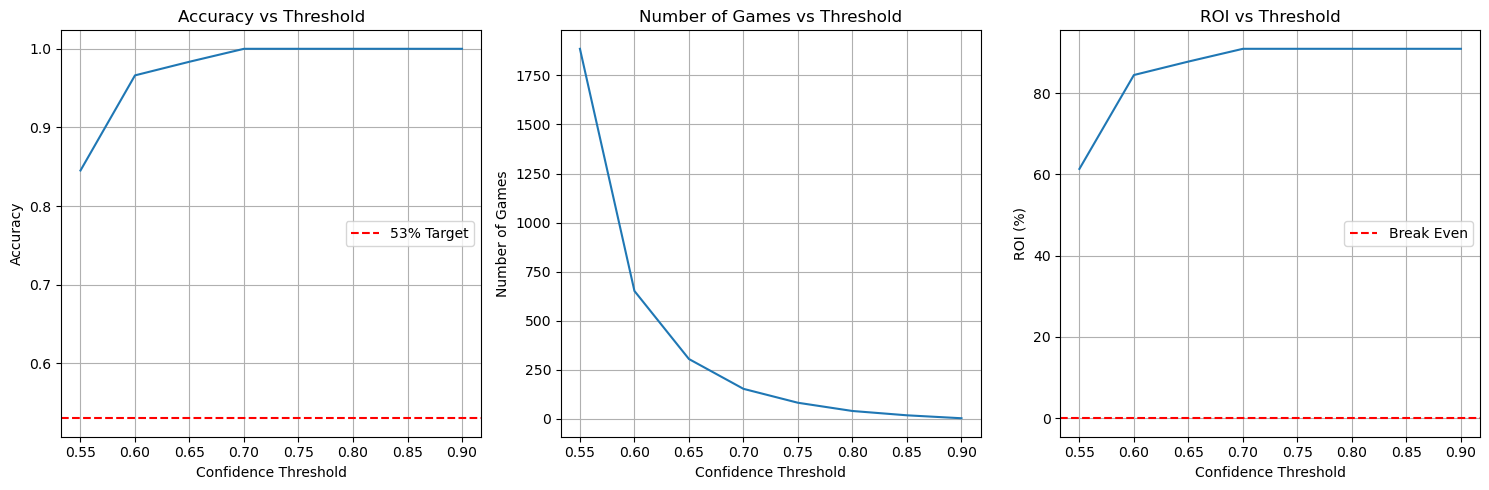

In [7]:
# Test multiple confidence thresholds to find the optimal balance
thresholds = [0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]
threshold_results = []

for threshold in thresholds:
    # Make predictions using this threshold
    predictions = predict_games(model, data_2023, threshold=threshold)
    
    # Calculate actual results
    predictions['home_margin'] = predictions['hscore'] - predictions['rscore']
    predictions['actual_covered'] = np.where(
        predictions['line'] > 0,
        predictions['home_margin'] > predictions['line'],  # Home is favored
        predictions['home_margin'] > predictions['line']   # Road is favored
    )
    
    # Get high confidence predictions
    high_conf = predictions[predictions['bet']]
    
    # Calculate metrics if there are any high confidence picks
    if len(high_conf) > 0:
        correct = sum(high_conf['predicted_covered'] == high_conf['actual_covered'])
        accuracy = correct / len(high_conf)
        roi = (correct * 100 - (len(high_conf) - correct) * 110) / (len(high_conf) * 110) * 100
        
        threshold_results.append({
            'threshold': threshold,
            'games': len(high_conf),
            'accuracy': accuracy,
            'roi': roi,
            'percentage_of_total': len(high_conf) / len(predictions) * 100
        })
    else:
        threshold_results.append({
            'threshold': threshold,
            'games': 0,
            'accuracy': 0,
            'roi': 0,
            'percentage_of_total': 0
        })

# Convert to DataFrame for easier analysis
threshold_df = pd.DataFrame(threshold_results)

# Print the results
print("Performance at different confidence thresholds:")
print(threshold_df)

# Find thresholds that meet the 53% accuracy criterion
valid_thresholds = threshold_df[threshold_df['accuracy'] >= 0.53]
if len(valid_thresholds) > 0:
    print("\nThresholds meeting 53%+ accuracy criterion:")
    print(valid_thresholds)
    
    # Find the threshold with the most games while maintaining 53%+ accuracy
    max_games_threshold = valid_thresholds.loc[valid_thresholds['games'].idxmax()]
    print("\nRecommended threshold for maximum volume while maintaining 53%+ accuracy:")
    print(f"Threshold: {max_games_threshold['threshold']}")
    print(f"Games: {max_games_threshold['games']} ({max_games_threshold['percentage_of_total']:.1f}% of total)")
    print(f"Accuracy: {max_games_threshold['accuracy']:.3f}")
    print(f"ROI: {max_games_threshold['roi']:.2f}%")
else:
    print("\nNo threshold meets the 53%+ accuracy criterion")

# Visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot 1: Accuracy vs Threshold
plt.subplot(1, 3, 1)
plt.plot(threshold_df['threshold'], threshold_df['accuracy'])
plt.axhline(y=0.53, color='r', linestyle='--', label='53% Target')
plt.title('Accuracy vs Threshold')
plt.xlabel('Confidence Threshold')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Plot 2: Number of Games vs Threshold
plt.subplot(1, 3, 2)
plt.plot(threshold_df['threshold'], threshold_df['games'])
plt.title('Number of Games vs Threshold')
plt.xlabel('Confidence Threshold')
plt.ylabel('Number of Games')
plt.grid(True)

# Plot 3: ROI vs Threshold
plt.subplot(1, 3, 3)
plt.plot(threshold_df['threshold'], threshold_df['roi'])
plt.axhline(y=0, color='r', linestyle='--', label='Break Even')
plt.title('ROI vs Threshold')
plt.xlabel('Confidence Threshold')
plt.ylabel('ROI (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# Cross-validation with proper feature engineering
from sklearn.model_selection import TimeSeriesSplit

# Convert date to datetime and sort data
data_sorted = data_2023.copy()
data_sorted['date'] = pd.to_datetime(data_sorted['date'], format='%m/%d/%Y')
data_sorted = data_sorted.sort_values('date')

# Define good line columns
good_line_columns = [
    'line', 'lineavg', 'linemoore', 'lineopen', 'linedok', 
    'linefox', 'linepugh', 'linetalis', 'lineespn', 'line7ot',
    'linemassey', 'lineround', 'lineteamrnks'
]

# Create time-based cross-validation splits
cv_results = []

# Define fold indices based on dates
fold_size = len(data_sorted) // 5
fold_indices = []
for i in range(5):
    if i < 4:
        test_indices = list(range(i * fold_size, (i + 1) * fold_size))
    else:
        test_indices = list(range(i * fold_size, len(data_sorted)))
    train_indices = [j for j in range(len(data_sorted)) if j not in test_indices]
    fold_indices.append((train_indices, test_indices))

# Run cross-validation
for fold, (train_index, test_index) in enumerate(fold_indices):
    print(f"Processing fold {fold+1}/5...")
    
    # Split data
    train_data = data_sorted.iloc[train_index].copy()
    test_data = data_sorted.iloc[test_index].copy()
    
    # Feature engineering on training data
    train_data['month'] = train_data['date'].dt.month
    train_data['day_of_week'] = train_data['date'].dt.dayofweek
    train_data['line_movement'] = train_data['line'] - train_data['lineopen']
    train_data['line_std'] = train_data[good_line_columns].std(axis=1)
    train_data['consensus_line'] = train_data[['linemassey', 'linemoore', 'lineavg']].mean(axis=1)
    train_data['line_value'] = train_data['line'] - train_data['consensus_line']
    
    for col in ['lineavg', 'linemoore', 'linemassey']:
        train_data[f'{col}_diff'] = train_data['line'] - train_data[col]
    
    # Create target
    train_data['home_margin'] = train_data['hscore'] - train_data['rscore']
    train_data['home_covered'] = np.where(
        train_data['line'] > 0,
        train_data['home_margin'] > train_data['line'],  # Home is favored
        train_data['home_margin'] > train_data['line']   # Road is favored
    )
    
    # Define features (make sure these match what your model expects)
    features = [
        'line', 'lineavg', 'linemoore', 'linemassey', 'std',
        'line_movement', 'line_std', 'line_value',
        'linemassey_diff', 'linemoore_diff', 'lineavg_diff',
        'month', 'day_of_week', 'neutral'
    ]
    
    # Create X and y
    X_train = train_data[features]
    y_train = train_data['home_covered']
    
    # Train model
    fold_model = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', GradientBoostingClassifier(n_estimators=100, random_state=42))
    ])
    
    fold_model.fit(X_train, y_train)
    
    # Make predictions
    predictions = predict_games(fold_model, test_data, threshold=0.55)
    
    # Calculate metrics
    if 'bet' in predictions.columns and sum(predictions['bet']) > 0:
        high_conf = predictions[predictions['bet']]
        high_conf['home_margin'] = high_conf['hscore'] - high_conf['rscore']
        high_conf['actual_covered'] = np.where(
            high_conf['line'] > 0,
            high_conf['home_margin'] > high_conf['line'],
            high_conf['home_margin'] > high_conf['line']
        )
        
        if len(high_conf) > 0:
            correct = sum(high_conf['predicted_covered'] == high_conf['actual_covered'])
            accuracy = correct / len(high_conf)
            roi = (correct * 100 - (len(high_conf) - correct) * 110) / (len(high_conf) * 110) * 100
        else:
            accuracy = 0
            roi = 0
        
        cv_results.append({
            'fold': fold + 1,
            'train_size': len(train_data),
            'test_size': len(test_data),
            'high_conf_games': len(high_conf),
            'accuracy': accuracy,
            'roi': roi
        })

# Display cross-validation results
cv_df = pd.DataFrame(cv_results)
print("\nCross-validation results:")
print(cv_df)
print(f"Average accuracy across folds: {cv_df['accuracy'].mean():.3f}")
print(f"Average ROI across folds: {cv_df['roi'].mean():.2f}%")

Processing fold 1/5...


/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_63947/509269907.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_conf['home_margin'] = high_conf['hscore'] - high_conf['rscore']
/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_63947/509269907.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_conf['actual_covered'] = np.where(


Processing fold 2/5...


/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_63947/509269907.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_conf['home_margin'] = high_conf['hscore'] - high_conf['rscore']
/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_63947/509269907.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_conf['actual_covered'] = np.where(


Processing fold 3/5...


/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_63947/509269907.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_conf['home_margin'] = high_conf['hscore'] - high_conf['rscore']
/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_63947/509269907.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_conf['actual_covered'] = np.where(


Processing fold 4/5...


/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_63947/509269907.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_conf['home_margin'] = high_conf['hscore'] - high_conf['rscore']
/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_63947/509269907.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_conf['actual_covered'] = np.where(


Processing fold 5/5...

Cross-validation results:
   fold  train_size  test_size  high_conf_games  accuracy       roi
0     1        4498       1124              539  0.525046  0.236128
1     2        4498       1124              456  0.502193 -4.126794
2     3        4498       1124              331  0.498489 -4.833837
3     4        4498       1124              350  0.482857 -7.818182
4     5        4496       1126              345  0.486957 -7.035573
Average accuracy across folds: 0.499
Average ROI across folds: -4.72%


/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_63947/509269907.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_conf['home_margin'] = high_conf['hscore'] - high_conf['rscore']
/var/folders/21/r3y1680j1xs9jgg6jhnydf3m0000gn/T/ipykernel_63947/509269907.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_conf['actual_covered'] = np.where(



Evaluating threshold: 0.6
  Processing fold 1/5...
  Processing fold 2/5...
  Processing fold 3/5...
  Processing fold 4/5...
  Processing fold 5/5...
  Avg Accuracy: 0.508, Avg ROI: -3.08%, Avg Games: 154.4

Evaluating threshold: 0.65
  Processing fold 1/5...
  Processing fold 2/5...
  Processing fold 3/5...
  Processing fold 4/5...
  Processing fold 5/5...
  Avg Accuracy: 0.546, Avg ROI: 4.32%, Avg Games: 75.2

Evaluating threshold: 0.7
  Processing fold 1/5...
  Processing fold 2/5...
  Processing fold 3/5...
  Processing fold 4/5...
  Processing fold 5/5...
  Avg Accuracy: 0.535, Avg ROI: 2.13%, Avg Games: 44.2

Evaluating threshold: 0.75
  Processing fold 1/5...
  Processing fold 2/5...
  Processing fold 3/5...
  Processing fold 4/5...
  Processing fold 5/5...
  Avg Accuracy: 0.598, Avg ROI: 14.16%, Avg Games: 27.8

Evaluating threshold: 0.8
  Processing fold 1/5...
  Processing fold 2/5...
  Processing fold 3/5...
  Processing fold 4/5...
  Processing fold 5/5...
  Avg Accuracy:

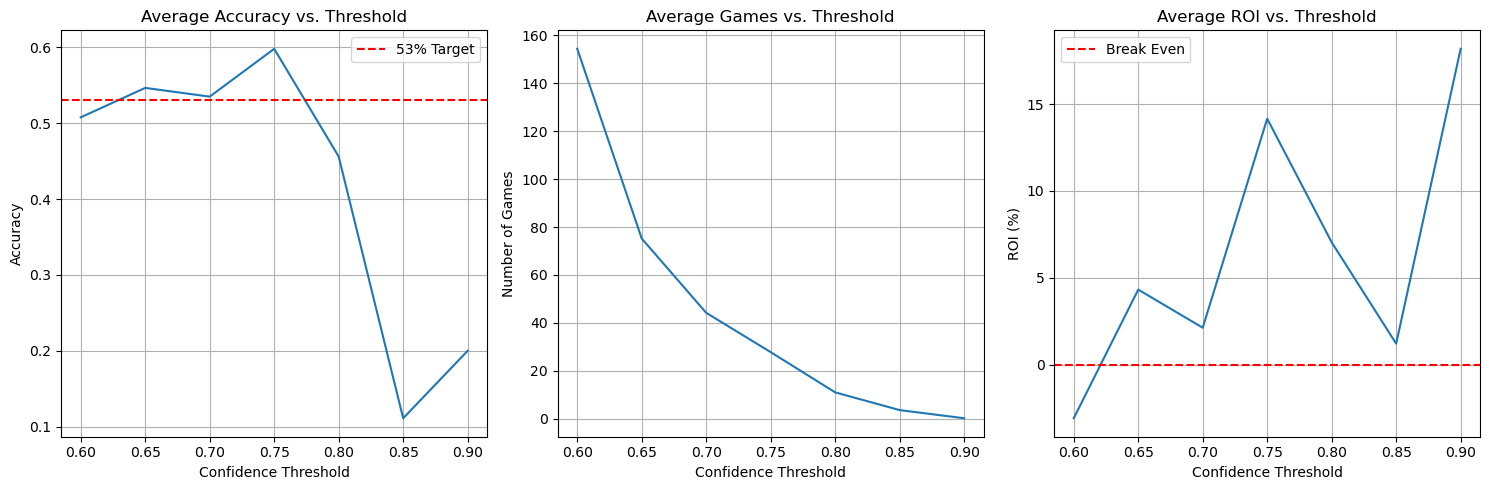

In [9]:
# Try with multiple confidence thresholds using cross-validation
thresholds = [0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]
threshold_results = []

# Re-use the same fold indices from your previous cross-validation
for threshold in thresholds:
    print(f"\nEvaluating threshold: {threshold}")
    cv_results = []
    
    for fold, (train_index, test_index) in enumerate(fold_indices):
        print(f"  Processing fold {fold+1}/5...")
        
        # Split data
        train_data = data_sorted.iloc[train_index].copy()
        test_data = data_sorted.iloc[test_index].copy()
        
        # Feature engineering on training data
        train_data['month'] = train_data['date'].dt.month
        train_data['day_of_week'] = train_data['date'].dt.dayofweek
        train_data['line_movement'] = train_data['line'] - train_data['lineopen']
        train_data['line_std'] = train_data[good_line_columns].std(axis=1)
        train_data['consensus_line'] = train_data[['linemassey', 'linemoore', 'lineavg']].mean(axis=1)
        train_data['line_value'] = train_data['line'] - train_data['consensus_line']
        
        for col in ['lineavg', 'linemoore', 'linemassey']:
            train_data[f'{col}_diff'] = train_data['line'] - train_data[col]
        
        # Create target
        train_data['home_margin'] = train_data['hscore'] - train_data['rscore']
        train_data['home_covered'] = np.where(
            train_data['line'] > 0,
            train_data['home_margin'] > train_data['line'],
            train_data['home_margin'] > train_data['line']
        )
        
        # Define features
        features = [
            'line', 'lineavg', 'linemoore', 'linemassey', 'std',
            'line_movement', 'line_std', 'line_value',
            'linemassey_diff', 'linemoore_diff', 'lineavg_diff',
            'month', 'day_of_week', 'neutral'
        ]
        
        # Create X and y
        X_train = train_data[features]
        y_train = train_data['home_covered']
        
        # Train model
        fold_model = Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('model', GradientBoostingClassifier(n_estimators=100, random_state=42))
        ])
        
        fold_model.fit(X_train, y_train)
        
        # Make predictions with the current threshold
        predictions = predict_games(fold_model, test_data, threshold=threshold)
        
        # Calculate metrics
        if 'bet' in predictions.columns and sum(predictions['bet']) > 0:
            high_conf = predictions[predictions['bet']].copy()  # Use .copy() to avoid warnings
            high_conf.loc[:, 'home_margin'] = high_conf['hscore'] - high_conf['rscore']
            high_conf.loc[:, 'actual_covered'] = np.where(
                high_conf['line'] > 0,
                high_conf['home_margin'] > high_conf['line'],
                high_conf['home_margin'] > high_conf['line']
            )
            
            if len(high_conf) > 0:
                correct = sum(high_conf['predicted_covered'] == high_conf['actual_covered'])
                accuracy = correct / len(high_conf)
                roi = (correct * 100 - (len(high_conf) - correct) * 110) / (len(high_conf) * 110) * 100
            else:
                accuracy = 0
                roi = 0
                
            cv_results.append({
                'fold': fold + 1,
                'high_conf_games': len(high_conf),
                'accuracy': accuracy,
                'roi': roi
            })
        else:
            cv_results.append({
                'fold': fold + 1,
                'high_conf_games': 0,
                'accuracy': 0,
                'roi': 0
            })
    
    # Calculate average metrics across folds
    cv_df = pd.DataFrame(cv_results)
    avg_accuracy = cv_df['accuracy'].mean()
    avg_roi = cv_df['roi'].mean()
    avg_games = cv_df['high_conf_games'].mean()
    
    # Store results for this threshold
    threshold_results.append({
        'threshold': threshold,
        'avg_accuracy': avg_accuracy,
        'avg_roi': avg_roi,
        'avg_games': avg_games,
        'folds_with_bets': sum(cv_df['high_conf_games'] > 0)
    })
    
    print(f"  Avg Accuracy: {avg_accuracy:.3f}, Avg ROI: {avg_roi:.2f}%, Avg Games: {avg_games:.1f}")

# Convert to DataFrame and display results
threshold_df = pd.DataFrame(threshold_results)
print("\nPerformance at different thresholds (cross-validated):")
print(threshold_df)

# Find the best threshold based on ROI
valid_thresholds = threshold_df[threshold_df['avg_games'] >= 5]  # Require at least 5 games on average
if len(valid_thresholds) > 0:
    best_threshold = valid_thresholds.loc[valid_thresholds['avg_roi'].idxmax(), 'threshold']
    best_performance = valid_thresholds.loc[valid_thresholds['avg_roi'].idxmax()]
    
    print("\nBest threshold based on ROI (with at least 5 games/fold):")
    print(f"Threshold: {best_threshold}")
    print(f"Average Accuracy: {best_performance['avg_accuracy']:.3f}")
    print(f"Average ROI: {best_performance['avg_roi']:.2f}%")
    print(f"Average Games: {best_performance['avg_games']:.1f}")
else:
    print("\nNo threshold meets the minimum games requirement")

# Visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(threshold_df['threshold'], threshold_df['avg_accuracy'])
plt.axhline(y=0.53, color='r', linestyle='--', label='53% Target')
plt.title('Average Accuracy vs. Threshold')
plt.xlabel('Confidence Threshold')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(threshold_df['threshold'], threshold_df['avg_games'])
plt.title('Average Games vs. Threshold')
plt.xlabel('Confidence Threshold')
plt.ylabel('Number of Games')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(threshold_df['threshold'], threshold_df['avg_roi'])
plt.axhline(y=0, color='r', linestyle='--', label='Break Even')
plt.title('Average ROI vs. Threshold')
plt.xlabel('Confidence Threshold')
plt.ylabel('ROI (%)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
import pickle# Load the 2024 prediction data
preds_data = pd.read_csv('ncaabbpreds-1.csv')

# Need to prepare the data the same way we did for training
def prepare_prediction_data(data):
    # Create a copy to avoid modifying the original
    prep_data = data.copy()
    
    # Add month and day of week (use current date for predictions)
    from datetime import datetime
    current_date = datetime.now()
    prep_data['month'] = current_date.month
    prep_data['day_of_week'] = current_date.weekday()
    
    # Calculate derived features
    prep_data['line_movement'] = prep_data['line'] - prep_data['lineopen']
    
    # Calculate line standard deviation
    good_line_columns = [
        'line', 'lineavg', 'linemoore', 'lineopen', 'linedok', 
        'linefox', 'linepugh', 'linetalis', 'lineespn', 'line7ot',
        'linemassey', 'lineround', 'lineteamrnks'
    ]
    
    # Use only columns that exist in the data
    available_line_cols = [col for col in good_line_columns if col in prep_data.columns]
    prep_data['line_std'] = prep_data[available_line_cols].std(axis=1)
    
    # Calculate consensus line and value
    consensus_columns = ['linemassey', 'linemoore', 'lineavg']
    available_consensus_cols = [col for col in consensus_columns if col in prep_data.columns]
    prep_data['consensus_line'] = prep_data[available_consensus_cols].mean(axis=1)
    prep_data['line_value'] = prep_data['line'] - prep_data['consensus_line']
    
    # Calculate difference features
    for col in ['lineavg', 'linemoore', 'linemassey']:
        if col in prep_data.columns:
            prep_data[f'{col}_diff'] = prep_data['line'] - prep_data[col]
    
    return prep_data

# Prepare prediction data
prepared_preds = prepare_prediction_data(preds_data)

# Load the trained model (if already saved)
try:
    model = load_model('ncaa_betting_model_final.pkl')
    print("Loaded existing model")
except:
    # If the model hasn't been saved, train it on the 2023 data
    print("Training new model on 2023 data")
    model = train_betting_model(data_2023)
    save_model(model, 'ncaa_betting_model_final.pkl')

# Define features needed for prediction
features = [
    'line', 'lineavg', 'linemoore', 'linemassey', 'std',
    'line_movement', 'line_std', 'line_value',
    'linemassey_diff', 'linemoore_diff', 'lineavg_diff',
    'month', 'day_of_week', 'neutral'
]

# Ensure all features exist (fill with 0 if missing)
for feature in features:
    if feature not in prepared_preds.columns:
        prepared_preds[feature] = 0

# Make predictions using optimal threshold (0.75 from cross-validation)
optimal_threshold = 0.75
X_pred = prepared_preds[features]

# Handle missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_pred_imputed = imputer.fit_transform(X_pred)

# Make predictions
probabilities = model.predict_proba(X_pred_imputed)
predictions = model.predict(X_pred_imputed)

# Add predictions to results
prepared_preds['predicted_covered'] = predictions
prepared_preds['confidence'] = np.max(probabilities, axis=1)
prepared_preds['p_covered'] = probabilities[:, 1]
prepared_preds['bet'] = prepared_preds['confidence'] >= optimal_threshold

# Add prediction details for clarity
def get_prediction_detail(row):
    line = row['line']
    if row['predicted_covered'] == 1:  # Model predicts cover
        if line > 0:
            return f"{row['home']} to cover as {line}-point favorite"
        else:
            return f"{row['home']} to cover as {abs(line)}-point underdog"
    else:  # Model predicts no cover
        if line > 0:
            return f"{row['road']} to cover against {line}-point home favorite"
        else:
            return f"{row['road']} to cover as {abs(line)}-point favorite"

prepared_preds['prediction_detail'] = prepared_preds.apply(get_prediction_detail, axis=1)

# Display recommendations
recommended_bets = prepared_preds[prepared_preds['bet']].sort_values('confidence', ascending=False)
print(f"\nRecommended bets (confidence >= {optimal_threshold}):")
print(f"Found {len(recommended_bets)} games to bet on")

if len(recommended_bets) > 0:
    print("\nBetting recommendations:")
    for _, bet in recommended_bets.iterrows():
        print(f"{bet['prediction_detail']} (confidence: {bet['confidence']:.3f})")
else:
    print("No games meet the confidence threshold for betting")

# Display all predictions for reference
print("\nAll predictions (including those below threshold):")
display(prepared_preds[['road', 'home', 'line', 'prediction_detail', 'confidence', 'bet']])

Loaded existing model

Recommended bets (confidence >= 0.75):
Found 0 games to bet on
No games meet the confidence threshold for betting

All predictions (including those below threshold):


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


,road,home,line,prediction_detail,confidence,bet
0,Oregon St.,Central Florida,5.0,Central Florida to cover as 5.0-point favorite,0.556568,False
1,DePaul,Cincinnati,10.0,DePaul to cover against 10.0-point home favorite,0.583854,False
2,Chattanooga,Loyola-Chicago,2.5,Loyola-Chicago to cover as 2.5-point favorite,0.511010,False
3,North Texas,UC Irvine,-1.5,North Texas to cover as 1.5-point favorite,0.502885,False
4,Tulane,USC,8.5,Tulane to cover against 8.5-point home favorite,0.530795,False
5,Colorado,Villanova,4.0,Villanova to cover as 4.0-point favorite,0.511257,False
